# Notebook to evaluate code-t5+ model for naming methods in Java code

Made for the JetBrains internship application by Marius De Kuthy Meurers

We use the "Salesforce/codet5p-220m" from Huggingface to predict method names previously extracted from the IntelliJ Community edition source code. The methods were extracted using a Java application located in `extract_methods`; the extracted methods are saved in JSON format in `extract_methods/output.json`

In this small lab, we use Pytorch Lightning to fine-tune the model and then evaluate whether there has been any improvement

This notebook is partly inspired by [this notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/T5/Fine_tune_CodeT5_for_generating_docstrings_from_Ruby_code.ipynb).


In [1]:
import json
import os
import re
from functools import reduce

import pandas as pd
import seaborn as sn
import torch
from Levenshtein import ratio, distance
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration

In [2]:
SEED = 42
CHECKPOINT = "Salesforce/codet5p-220m"
# we use the tokenizer in multithreaded enviroments this seems to cause some issues otherwise
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.set_float32_matmul_precision('medium')

In [3]:
def tokenize_data(samples, tokenizer, max_input_length=1024, max_target_length=128):
    # encode the code-docstring pairs
    method_bodys = samples['method']
    method_names = samples['name']

    # encode the method_bodys
    model_inputs = tokenizer(method_bodys.tolist(), max_length=max_input_length, padding="max_length", truncation=True,
                             return_tensors="pt")

    # encode the summaries
    labels = tokenizer(method_names.tolist(), max_length=max_target_length, padding="max_length", truncation=True,
                       return_tensors="pt").input_ids

    # important: we need to replace the index of the padding tokens by -100
    # such that they are not taken into account by the CrossEntropyLoss
    labels[labels == tokenizer.pad_token_id] = -100

    model_inputs["labels"] = labels

    return model_inputs

## Define the Dataset

We use a `LightningDataModule` to bundle all our data into a class usable by PytorchLightning.

The data that we read has three columns: 
* `method`: The whole method as it is in the Java source code, including annotations such as `@Override`
* `name`: The method name
* `hasBody`: A boolean that indicates, whether the method has a body or not, so whether the method has any code inside of its definition

Most importantly, here we do some data preprocessing in `prepare_data`
* All methods that have more than 512 Tokens in length are removed so that we don't have truncated methods in our dataset
* Only keep methods that have a body
* Replace the method name with the span tag `<extra_id_0>`
* Add the same span tag before the label
* Tokenize all the data

In [4]:
class MethodDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data["input_ids"])

    def __getitem__(self, idx):
        return self.data["input_ids"][idx], self.data["attention_mask"][idx], self.data["labels"][idx]


class CustomDataModule(LightningDataModule):
    def __init__(self, data_file, tokenizer, batch_size=8, num_workers=4, max_input_length=1024, max_target_length=128,
                 mask_token="<extra_id_0>"):
        super().__init__()
        self.data_file = data_file
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.mask_token = mask_token
        self.test_idx = None
        self.train_val_idx = None
        self.data = None
        self.dataset = None
        self.val_dataset = None
        self.train_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        if self.data is not None and self.train_val_idx is not None and self.test_idx is not None:
            return

        with open(self.data_file, "r") as f:
            self.data = json.loads(f.read())
        self.data = pd.DataFrame(self.data["input"])
        # remove all samples with a method body longer than max_length tokens or a method name longer than 64 tokens
        self.data = self.data[
            (self.data["method"].str.len() <= max_input_length) & (self.data["name"].str.len() <= max_target_length)]

        # remove all samples with no method body
        self.data = self.data[self.data["hasBody"] == True]

        # replace in each row in the method body the method name by <extra_id_0>
        self.data.loc[:, "method"] = self.data.apply(lambda row: row["method"].replace(row["name"], self.mask_token),
                                                     axis=1)

        # add the <extra_id_0> token before each method name
        self.data.loc[:, "name"] = self.data.apply(lambda row: self.mask_token + row["name"], axis=1)

        # tokenize the data
        self.data = tokenize_data(self.data, self.tokenizer, max_input_length=self.max_input_length,
                                  max_target_length=self.max_target_length)

        self.train_val_idx, self.test_idx = train_test_split(range(len(self.data["input_ids"])), test_size=0.1,
                                                             random_state=SEED)

    def setup(self, stage: str):
        if stage == "fit":
            kfold = KFold(n_splits=10, random_state=SEED, shuffle=True)
            split = list(kfold.split(self.data["input_ids"][self.train_val_idx]))
            train_idx, valid_idx = split[0]
            self.train_dataset = MethodDataset({k: v[train_idx] for k, v in self.data.items()})
            self.val_dataset = MethodDataset({k: v[valid_idx] for k, v in self.data.items()})
        if stage == "test":
            self.test_dataset = MethodDataset({k: v[self.test_idx] for k, v in self.data.items()})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def predict_dataloader(self):
        raise NotImplementedError

### Initialize the DataModule

The variables here are chosen to use the most of my local computer(Nvidia 3080 with 10GB VRAM). The `max_input_length` could be increased to allow for longer methods to be classified, but as the size increases, it quadratically increases the model size in the VRAM. In order to have a larger `batch_size` and thus smaller training time, I decided on 512.

In [5]:
batch_size = 8
num_workers = 32
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
mask_token = "<extra_id_0>"
device = "cuda"
max_input_length = 512
max_target_length = 64
data_file = "extract_methods/output.json"

data_module = CustomDataModule(data_file, tokenizer, batch_size=batch_size, num_workers=num_workers,
                               max_input_length=max_input_length, max_target_length=max_target_length,
                               mask_token=mask_token)

Even after sorting out some of the data, we still have 99040 samples for training, testing, and validation.

In [6]:
data_module.prepare_data()
len(data_module.data["input_ids"])

99040

## Defining the training infrastructure

In this `LightningModule` class, we define how our predefined model is trained and evaluated.

### Levenshtein distance

To evaluate how well the model performs, I use the Levenshtein distance. This number tells you how many character changes would be needed to get to the label. I chose this metric because method names are single words, and this metric seemed to show a good performance in initial tests.

In the code, to extract the method name from the predicted tokens, we use a regex to extract the first word after the `<extra_id_0>` token. 
After that, we calculate three values using [this Levenshtein implementation in Python](https://github.com/rapidfuzz/Levenshtein)
* `distance` the standard Levenshtein distance
* `distance_normalized` the Levenshtein distance divided by the length of the label, so that longer words aren't weighted as much
* `ratio` calculates a normalized indel similarity in the range [0, 1] ([from the documentation](https://rapidfuzz.github.io/Levenshtein/levenshtein.html#ratio))

### Learning Rate Scheduler and Optimizer

We use a CosineAnnealingLR that decreases each step to schedule the learning rate. 
The AdamW Optimizer is used in many other research projects.

In [7]:
class CustomTransformer(LightningModule):
    def __init__(self, tokenizer_factory, batch_size=4, lr=5e-5, num_train_epochs=15):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(CHECKPOINT)
        self.tokenizer_factory = tokenizer_factory
        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(input_ids, attention_mask=attention_mask, labels=labels)

    def levenshtein(self, preds_tokens, labels_tokens):
        # use levenshtein ratio to calculate the accuracy
        tokenizer = self.tokenizer_factory()

        pred = tokenizer.batch_decode(preds_tokens)
        # extract first word after <extra_id_0> token
        pred = map(lambda x: re.findall(r"<extra_id_0>[^\w<]*(\w+)", x), pred)
        # if no <extra_id_0> token is found, return empty string
        pred = list(map(lambda x: x[0] if len(x) > 0 else "", pred))

        # remove the -100 labels for padding tokens, because they cause issues
        labels = map(lambda x: x[x != -100], labels_tokens)
        labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        distances = map(lambda x, y: distance(x, y), pred, labels)
        distances = reduce(lambda x, y: x + y, distances) / len(preds_tokens)
        distances_normalized = map(lambda x, y, z: distance(x, y) / z, pred, labels, map(lambda x: max(len(x), 1), labels))
        distances_normalized = reduce(lambda x, y: x + y, distances_normalized) / len(preds_tokens)
        
        ratios = map(lambda x, y: ratio(x, y), pred, labels)
        ratios = reduce(lambda x, y: x + y, ratios) / len(preds_tokens)

        return ratios, distances, distances_normalized

    def evaluate(self, batch, stage=None):
        input_ids, attention_mask, labels = batch
        # reduce memory usage by using fp16

        outputs = self(input_ids, attention_mask, labels=labels)
        loss = outputs.loss

        if stage is not None:
            preds = outputs.logits.argmax(dim=-1)
            ratio, dist, dist_norm = self.levenshtein(preds, labels)
            self.log(f"{stage}_l_ratio", ratio, prog_bar=True)
            self.log(f"{stage}_l_dist", dist, prog_bar=True)
            self.log(f"{stage}_l_dist_norm", dist_norm, prog_bar=True)
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_lr", self.trainer.optimizers[0].param_groups[0]["lr"], prog_bar=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="val")

    def test_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="test")

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        input_ids, attention_mask = batch
        outputs = self.generate(input_ids=input_ids, attention_mask=attention_mask,
                                max_length=64 + len(self.tokenizer_factory().eos_token),
                                num_beams=5, early_stopping=True)
        preds = self.tokenizer_factory().decode(outputs, skip_special_tokens=True)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.num_train_epochs * len(data_module.train_dataloader()),
                                                                     eta_min=0),
            "interval": "step",
            "frequency": 1
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


## Initialize the Trainer

Before fine-tuning the model, we initialize our Transformer module and then the trainer.

* Because of limited training time, only 1 epoch was trained.
* 16 Bit precision was used so that GPU memory could be saved for higher batch sizes

In [8]:
tokenizer_factory = lambda: AutoTokenizer.from_pretrained(CHECKPOINT)

num_epochs = 1

model = CustomTransformer(tokenizer_factory, batch_size=batch_size, lr=5e-5, num_train_epochs=num_epochs)
trainer = Trainer(devices=1,
                  accelerator="cuda",
                  max_epochs=num_epochs,
                  logger=CSVLogger(save_dir="logs", name="codet5"),
                  callbacks=[
                      ModelCheckpoint(dirpath=".", save_top_k=1, monitor="train_loss", mode="min", filename='{step}-{train_loss:.3f}'),
                      LearningRateMonitor(logging_interval="step"),
                      # EarlyStopping(monitor="train_loss", patience=10, verbose=True, mode="min")
                  ],
                  precision="16-true")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, data_module)

/home/deep/.virtualenvs/jetbrains_internship_local/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:43: attribute 'tokenizer_factory' removed from hparams because it cannot be pickled
/home/deep/.virtualenvs/jetbrains_internship_local/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /tmp/pycharm_project_376 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.528   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

/home/deep/.virtualenvs/jetbrains_internship_local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


In [9]:
# save models for later use
model.model.save_pretrained("codet5")
trainer.save_checkpoint("codet5.ckpt")

# Evaluation

## Plotting the learning progress

By plotting the logs we can learn some things about the trainng
* The plots of the learning progress don't show a good learning progression
    * The training loss is all over the place and doesn't show a linear decrease over the training, the same is for our metric the Levenshtein distance.
* The loss and the Levenshtein distance correclate, this shows that the levenshtein distance is a good indicator on how good our prediciton is
* In the middle of the training progression there must be a part, where very easy method names are placed, because there the model is predicting all models right.

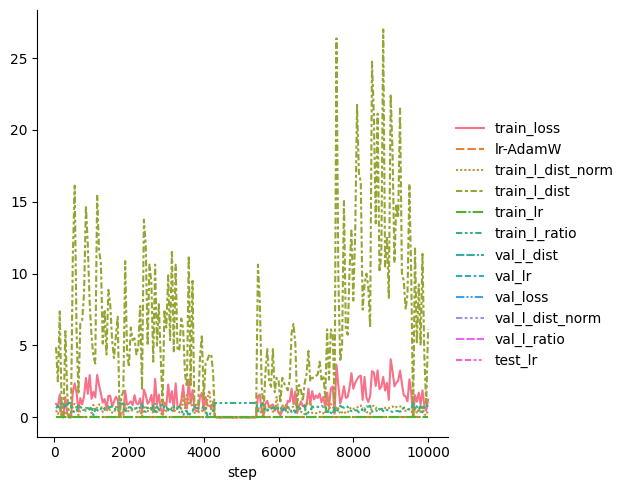

In [51]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics.drop(columns=["test_loss", "test_l_dist", "test_l_dist_norm", "test_l_ratio", "epoch"], inplace=True)
metrics.set_index("step", inplace=True)
# display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

## Run the test data on the fine tuned model

In [17]:
test_out = trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_l_dist           5.955270767211914
    test_l_dist_norm        0.48828810453414917
      test_l_ratio           0.670490562915802
        test_loss           1.2201871871948242
         test_lr                    0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Run the test data on the base model 

In [19]:
base_model = CustomTransformer(tokenizer_factory, batch_size=batch_size, lr=5e-5, num_train_epochs=num_epochs)
base_test_out = trainer.test(base_model, datamodule=data_module)

/home/deep/.virtualenvs/jetbrains_internship_local/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:43: attribute 'tokenizer_factory' removed from hparams because it cannot be pickled
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_l_dist          11.112581253051758
    test_l_dist_norm         1.223065733909607
      test_l_ratio          0.24719402194023132
        test_loss           10.193760871887207
         test_lr                    0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Compare the models

While the training graph shows no clear increase in learning the testing does show a clear improvement in all metrics.
Most importantly the loss is only a 10th of the size as without fine tuning.

In [43]:
test_out[0]["model"] = CHECKPOINT + "-finetuned"
base_test_out[0]["model"] = CHECKPOINT
output_data = pd.DataFrame([*test_out, *base_test_out])
output_data.set_index("model", inplace=True)
output_data.rename(columns={"test_loss": "loss", "test_l_dist": "Levenshtein distance", "test_l_dist_norm": "Levenshtein distance normalized", "test_l_ratio": "Levenshtein ratio"}, inplace=True)
output_data.drop(columns=["test_lr"], inplace=True)
display(output_data)

,Levenshtein ratio,Levenshtein distance,Levenshtein distance normalized,loss
model,,,,
Salesforce/codet5p-220m-finetuned,0.670491,5.955271,0.488288,1.220187
Salesforce/codet5p-220m,0.247194,11.112581,1.223066,10.193761
